# CheXpert Data Exploration

In [1]:
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import matplotlib as plt

Using TensorFlow backend.


In [2]:
#read in the training dataset
train=pd.read_csv("CheXpert-v1.0-small/train.csv", dtype = str)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
Path                          223414 non-null object
Sex                           223414 non-null object
Age                           223414 non-null object
Frontal/Lateral               223414 non-null object
AP/PA                         191027 non-null object
No Finding                    22381 non-null object
Enlarged Cardiomediastinum    44839 non-null object
Cardiomegaly                  46203 non-null object
Lung Opacity                  117778 non-null object
Lung Lesion                   11944 non-null object
Edema                         85956 non-null object
Consolidation                 70622 non-null object
Pneumonia                     27608 non-null object
Atelectasis                   68443 non-null object
Pneumothorax                  78934 non-null object
Pleural Effusion              133211 non-null object
Pleural Other                 6492 non-null object

In [3]:
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


[]

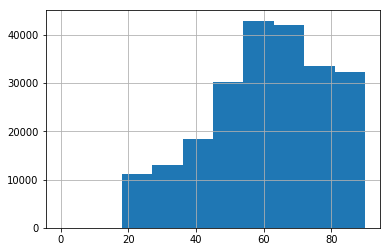

In [15]:
import matplotlib as plt
train['Age'] = train['Age'].astype(str).astype(int)
train['Age'].hist().plot()

In [10]:
new = train["Path"].str.split("/", n = 5, expand = True)

train['Folder'] = new[0]
train['Data'] = new[1]
train['Patient'] = new[2]
train['Study'] = new[3]
train['viewNumber']= new[4].str.split("_", n = 2, expand = True)[0]
train['ImageType']= new[4].str.split("_", n = 2, expand = True)[1]

train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,Folder,Data,Patient,Study,viewNumber,ImageType
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,CheXpert-v1.0-small,train,patient00001,study1,view1,frontal.jpg
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,1.0,NaN,CheXpert-v1.0-small,train,patient00002,study2,view1,frontal.jpg
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,CheXpert-v1.0-small,train,patient00002,study1,view1,frontal.jpg
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,CheXpert-v1.0-small,train,patient00002,study1,view2,lateral.jpg
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,CheXpert-v1.0-small,train,patient00003,study1,view1,frontal.jpg


In [27]:
train['ImageType'].value_counts()

frontal.jpg    191027
lateral.jpg     32387
Name: ImageType, dtype: int64

In [50]:
train['Study'].value_counts()

study1     82203
study2     36501
study3     22924
study4     15978
study5     11746
study6      8789
study7      6874
study8      5517
study9      4521
study10     3719
study11     3095
study12     2603
study13     2195
study14     1883
study15     1627
study16     1408
study17     1226
study18     1063
study19      929
study20      825
study21      725
study22      652
study23      588
study24      503
study25      474
study26      421
study27      382
study28      345
study29      310
study30      288
           ...  
study62       23
study64       21
study63       20
study65       18
study66       15
study67       15
study68       14
study70       13
study69       13
study71       13
study72       11
study74       11
study73       11
study75       10
study76       10
study77        6
study80        3
study79        3
study78        3
study84        3
study86        3
study85        3
study82        3
study83        3
study81        3
study89        2
study87        2
study88       

In [17]:
train.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'Folder', 'Data', 'Patient', 'Study', 'viewNumber',
       'ImageType'],
      dtype='object')

In [25]:
pathology = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture','Support Devices']

for p in pathology:
    print(p)
    train[p].loc[train[p].isna()] = '0.0'
    print(train[p].value_counts())


No Finding
0.0    201033
1.0     22381
Name: No Finding, dtype: int64
Enlarged Cardiomediastinum
0.0     200213
-1.0     12403
1.0      10798
Name: Enlarged Cardiomediastinum, dtype: int64
Cardiomegaly
0.0     188327
1.0      27000
-1.0      8087
Name: Cardiomegaly, dtype: int64
Lung Opacity
0.0     112235
1.0     105581
-1.0      5598
Name: Lung Opacity, dtype: int64
Lung Lesion
0.0     212740
1.0       9186
-1.0      1488
Name: Lung Lesion, dtype: int64
Edema
0.0     158184
1.0      52246
-1.0     12984
Name: Edema, dtype: int64
Consolidation
0.0     180889
-1.0     27742
1.0      14783
Name: Consolidation, dtype: int64
Pneumonia
0.0     198605
-1.0     18770
1.0       6039
Name: Pneumonia, dtype: int64
Atelectasis
0.0     156299
-1.0     33739
1.0      33376
Name: Atelectasis, dtype: int64
Pneumothorax
0.0     200821
1.0      19448
-1.0      3145
Name: Pneumothorax, dtype: int64
Pleural Effusion
0.0     125599
1.0      86187
-1.0     11628
Name: Pleural Effusion, dtype: int64
Pleura

In [48]:
patients = train[['Patient','Sex','Age']].drop_duplicates().groupby(['Patient','Sex']).count()
patients[patients > 1].count()

Study    30976
dtype: int64

In [36]:
patients['Age'].describe()

count    79035.000000
mean        60.677700
std         18.429729
min          0.000000
25%         48.000000
50%         62.000000
75%         75.000000
max         90.000000
Name: Age, dtype: float64

In [51]:
patients = train[['Patient','Sex','Age']]
patients

,Patient,Sex,Age
0,patient00001,Female,68
1,patient00002,Female,87
2,patient00002,Female,83
3,patient00002,Female,83
4,patient00003,Male,41
5,patient00004,Female,20
6,patient00004,Female,20
7,patient00005,Male,33
8,patient00005,Male,33
9,patient00005,Male,33
